<a href="https://colab.research.google.com/github/dongzooo/DeepLearning_AI-TensorFlow/blob/main/B_%EB%AC%B8%EC%A0%9C_3%EB%B2%88_A_horses_or_human_TF_Certificate_3_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98_(horses_or_humans)_%EC%8B%A4%EC%8A%B5_%ED%95%B4%EC%84%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Category 3

Convolution Neural Network (합성곱 신경망)를 활용한 이미지 분류 (Image Classification)

## 확인

1. GPU 옵션 켜져 있는지 확인할 것!!! (수정 - 노트설정 - 하드웨어설정 (GPU))

## 순서

1. **import**: 필요한 모듈 import
2. **전처리**: 학습에 필요한 데이터 전처리를 수행합니다.
3. **모델링(model)**: 모델을 정의합니다.
4. **컴파일(compile)**: 모델을 생성합니다.
5. **학습 (fit)**: 모델을 학습시킵니다.

## 문제

This task requires you to create a classifier for horses or humans using
the provided dataset. 

Please make sure your final layer has 2 neurons, activated by softmax 
as shown. Do not change the provided output layer, or tests may fail.

IMPORTANT: Please note that the test uses images that are 300x300 with 
3 bytes color depth so be sure to design your input layer to accept
these, or the tests will fail.

-------------------------------

이 작업에서는 다음을 사용하여 말이나 사람을위한 분류기를 만들어야합니다.

최종 레이어에 softmax에 의해 활성화 된 2 개의 뉴런이 있는지 확인하십시오

중요 : 테스트에는 300x300 크기의 이미지가 사용됩니다.
3 바이트 색상 심도이므로 입력 레이어를 수용하도록 설계하십시오

-----------------------------------


# 실습

## STEP 1. import 

In [ ]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

## STEP 1. Load Dataset

말과 사람을 구분하는 **이진 분류 (Binary Classification)** 문제입니다.

In [ ]:
_TRAIN_URL = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"
_TEST_URL = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"

urllib.request.urlretrieve(_TRAIN_URL, 'horse-or-human.zip')

local_zip = 'horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/horse-or-human/')
zip_ref.close()

urllib.request.urlretrieve(_TEST_URL, 'validation-horse-or-human.zip')
local_zip = 'validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/validation-horse-or-human/')
zip_ref.close()

Found 1027 images belonging to 2 classes.
(128, 300, 300, 3) (128, 2)
[1. 0.]


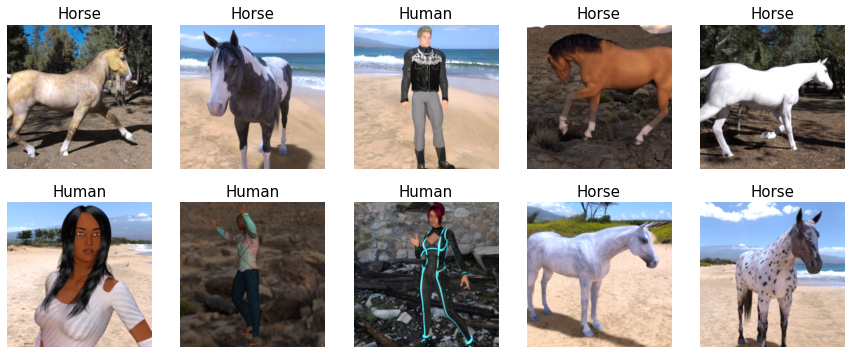

In [ ]:
import matplotlib.pyplot as plt

class_map = {
    0: 'Horse',
    1: 'Human', 
}

original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory('tmp/horse-or-human/', 
                                                          batch_size=128, 
                                                          target_size=(300, 300), 
                                                          class_mode='categorical'
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    break
plt.show()

## STEP 2. 전처리 (ImageDataGenerator)

데이터셋의 경로를 지정해 주세요 (root 폴더의 경로를 지정하여야 합니다.)


**[코드]**

In [ ]:
TRAINING_DIR = 'tmp/horse-or-human/'
VALIDATION_DIR = 'tmp/validation-horse-or-human/'

`ImageDataGenerator`를 정의합니다.

다음의 옵션 값들로 Image Aumentation(이미지 변형) 옵션을 적절히 조절해 주세요

* `rescale`: 이미지의 픽셀 값을 조정
* `rotation_range`: 이미지 회전
* `width_shift_range`: 가로 방향으로 이동
* `height_shift_range`: 세로 방향으로 이동
* `shear_range`: 이미지 굴절
* `zoom_range`: 이미지 확대
* `horizontal_flip`: 횡 방향으로 이미지 반전
* `fill_mode`: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
* `validation_split`: validation set의 구성 비율

[코드]

In [ ]:
training_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='reflect',     
)

In [ ]:
#검증데이터에서는 rescale만 준다!!
validation_datagen = ImageDataGenerator(
    rescale=1/ 255.0,
)

ImageDataGenerator를 잘 만들어 주었다면, `flow_from_directory`로 이미지를 어떻게 공급해 줄 것인가를 지정해 주어야합니다.

* train / validation set 전용 generator를 별도로 정의합니다.
* `batch_size`를 정의합니다.
* `target_size`를 정의합니다. (300 x 300). 이미지를 알아서 타겟 사이즈 만큼 잘라내어 공급합니다.
* `class_mode`는 3개 이상의 클래스인 경우 'categorical', 이진 분류의 경우 `binary`를 지정합니다.
* `subset`을 지정합니다. (training / validation)


**training_generator**에 대한 `from_from_directory`를 정의합니다.

**[코드]**

In [ ]:
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(300, 300),
    batch_size=128,
    class_mode='binary',
)

Found 1027 images belonging to 2 classes.


**validation_generator**에 대한 `from_from_directory`를 정의합니다.

**[코드]**

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(300, 300),
    batch_size=128,
    class_mode='binary',
)

Found 256 images belonging to 2 classes.


## STEP 3. 모델 정의 (Sequential)

In [ ]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
from keras.applications.vgg16 import VGG16

transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
transfer_model.trainable=False

model = tf.keras.models.Sequential([
    transfer_model,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 41472)             0         
                                                                 
 dropout_2 (Dropout)         (None, 41472)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               10617088  
                                                                 
 dense_7 (Dense)             (None, 32)                8224      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 25,340,033
Trainable params: 10,625,345


## STEP 4. 컴파일 (compile)

1. `optimizer`는 가장 최적화가 잘되는 알고리즘인 'adam'을 사용합니다.
2. `loss`는 무엇을 지정하면 좋을까요?
3. `metrics`를 'acc' 혹은 'accuracy'로 지정하면, 학습시 정확도를 모니터링 할 수 있습니다.

**[코드]**

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

## STEP 5. ModelCheckpoint

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

**[코드]**

In [ ]:
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

## STEP 6. 학습 (fit)

**[코드]**

In [ ]:
model.fit(train_generator, 
          validation_data=(validation_generator),
          epochs=20,
          callbacks=[checkpoint],
          )

Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 1.5494 - acc: 0.7274
Epoch 1: val_loss improved from inf to 0.36107, saving model to tmp_checkpoint.ckpt
9/9 [==============================] - 49s 3s/step - loss: 1.5494 - acc: 0.7274 - val_loss: 0.3611 - val_acc: 0.8398
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 0.0724 - acc: 0.9757
Epoch 2: val_loss improved from 0.36107 to 0.25242, saving model to tmp_checkpoint.ckpt
9/9 [==============================] - 30s 3s/step - loss: 0.0724 - acc: 0.9757 - val_loss: 0.2524 - val_acc: 0.9180
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 0.0592 - acc: 0.9796
Epoch 3: val_loss improved from 0.25242 to 0.09867, saving model to tmp_checkpoint.ckpt
9/9 [==============================] - 30s 3s/step - loss: 0.0592 - acc: 0.9796 - val_loss: 0.0987 - val_acc: 0.9570
Epoch 4/20
9/9 [==============================] - ETA: 0s - loss: 0.0290 - acc: 0.9903
Epoch 4: val_loss improved from 0.09867 t

## STEP 7. 학습 완료 후 Load Weights (ModelCheckpoint)

학습이 완료된 후에는 반드시 `load_weights`를 해주어야 합니다.

그렇지 않으면, 열심히 ModelCheckpoint를 만든 의미가 없습니다.

**[코드]**

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
model.save("TF3-horses-or-humans-type-B_VGG.h5")